<a href="https://colab.research.google.com/github/abeersethia/CCM_EEG/blob/main/GilpinPaper_Lorenz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lorenz Attractor Reconstruction using Gilpin's Paper

Epoch 001 | Loss: 23.7117
Epoch 002 | Loss: 22.3255
Epoch 003 | Loss: 14.5164
Epoch 004 | Loss: 8.1864
Epoch 005 | Loss: 5.3427
Epoch 006 | Loss: 3.8152
Epoch 007 | Loss: 3.1159
Epoch 008 | Loss: 2.7472
Epoch 009 | Loss: 2.4623
Epoch 010 | Loss: 2.2235
Epoch 011 | Loss: 2.0388
Epoch 012 | Loss: 1.8272
Epoch 013 | Loss: 1.6572
Epoch 014 | Loss: 1.5163
Epoch 015 | Loss: 1.4194
Epoch 016 | Loss: 1.3512
Epoch 017 | Loss: 1.2869
Epoch 018 | Loss: 1.2158
Epoch 019 | Loss: 1.1692
Epoch 020 | Loss: 1.1161
Epoch 021 | Loss: 1.0889
Epoch 022 | Loss: 1.0617
Epoch 023 | Loss: 1.0185
Epoch 024 | Loss: 0.9930
Epoch 025 | Loss: 0.9773
Epoch 026 | Loss: 0.9666
Epoch 027 | Loss: 0.9462
Epoch 028 | Loss: 0.9299
Epoch 029 | Loss: 0.9246
Epoch 030 | Loss: 0.8986
Epoch 031 | Loss: 0.8990
Epoch 032 | Loss: 0.8761
Epoch 033 | Loss: 0.8660
Epoch 034 | Loss: 0.8708
Epoch 035 | Loss: 0.8696
Epoch 036 | Loss: 0.8479
Epoch 037 | Loss: 0.8397
Epoch 038 | Loss: 0.8428
Epoch 039 | Loss: 0.8173
Epoch 040 | Loss: 0.83

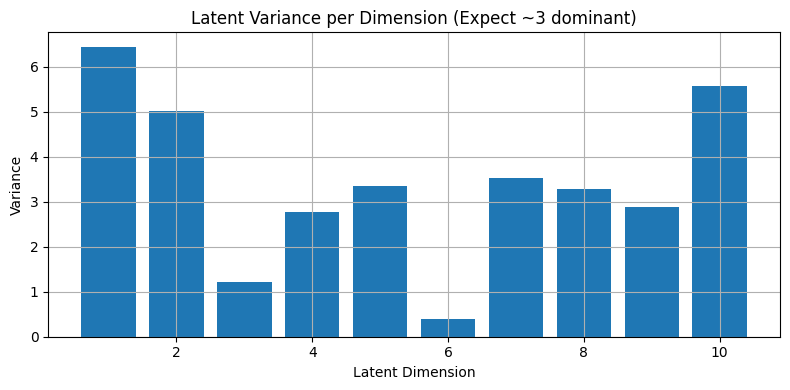

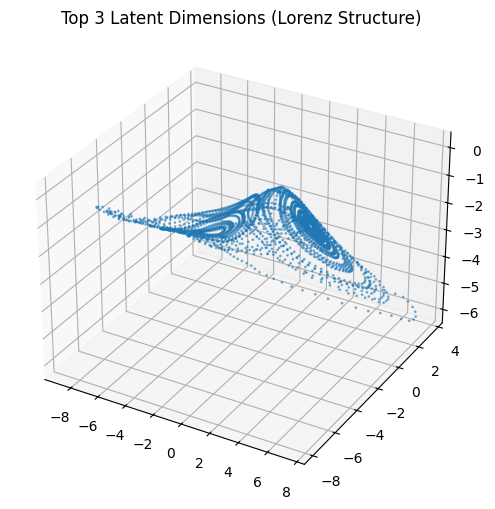

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D

# Set random seeds
np.random.seed(0)
torch.manual_seed(0)

# Step 1: Generate and normalize full 3D Lorenz system
def generate_lorenz(n_steps=3000, dt=0.01, sigma=10, rho=28, beta=8/3):
    traj = np.zeros((n_steps, 3))
    traj[0] = [1.0, 1.0, 1.0]
    for i in range(1, n_steps):
        x, y, z = traj[i - 1]
        dx = sigma * (y - x)
        dy = x * (rho - z) - y
        dz = x * y - beta * z
        traj[i] = traj[i - 1] + dt * np.array([dx, dy, dz])
    return traj

lorenz = generate_lorenz()
lorenz = (lorenz - lorenz.mean(axis=0)) / lorenz.std(axis=0)  # Normalize 3D

# Step 2: Multivariate delay embedding
def create_multidim_delay_embedding(data, T, tau=2):
    N = data.shape[0] - (T - 1) * tau
    d = data.shape[1]
    embedded = np.zeros((N, T * d))
    for i in range(N):
        window = [data[i + j * tau] for j in range(T)]
        embedded[i] = np.concatenate(window)
    return embedded

T = 10  # Number of delay steps
tau = 2
X = create_multidim_delay_embedding(lorenz, T, tau)  # Input shape: (N, 30)
X_tensor = torch.tensor(X, dtype=torch.float32)
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Step 3: Autoencoder (Gilpin-style)
class GilpinAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=6):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

model = GilpinAutoencoder(input_dim=X.shape[1], latent_dim=10)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=75, gamma=0.5)
mse_loss = nn.MSELoss()

# Step 4: FNN loss (non-differentiable, auxiliary)
def fnn_loss(z, K=5):
    z = z.detach().cpu().numpy()
    N, L = z.shape
    variances = np.var(z, axis=0)
    total_loss = 0.0

    for m in range(1, L):
        z_m = z[:, :m]
        z_m1 = z[:, :m+1]
        nbrs = NearestNeighbors(n_neighbors=K+1).fit(z_m)
        _, idx = nbrs.kneighbors(z_m)
        idx = idx[:, 1:]

        retained = []
        for i in range(N):
            d_m = np.linalg.norm(z[i, :m] - z[idx[i], :m], axis=1)
            d_m1 = np.linalg.norm(z[i, :m+1] - z[idx[i], :m+1], axis=1)
            R = d_m1 / (d_m + 1e-6)
            retained.append(np.mean(R < 10))

        fnn_term = np.mean(1 - np.array(retained)) * variances[m]
        total_loss += fnn_term

    return total_loss / (L - 1)

# Step 5: Train model
EPOCHS = 300
lambda_fnn = 1e-1

for epoch in range(EPOCHS):
    model.train()
    total_epoch_loss = 0.0
    for batch in dataloader:
        x = batch[0]
        x_hat, z = model(x)
        recon_loss = mse_loss(x_hat, x)
        fnn = fnn_loss(z.detach())
        loss = recon_loss + lambda_fnn * fnn
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_epoch_loss += loss.item()

    scheduler.step()
    print(f"Epoch {epoch+1:03d} | Loss: {total_epoch_loss:.4f}")

# Step 6: Variance of latent dimensions
model.eval()
with torch.no_grad():
    _, z = model(X_tensor)
    z_np = z.numpy()
    variances = np.var(z_np, axis=0)

plt.figure(figsize=(8, 4))
plt.bar(range(1, len(variances)+1), variances)
plt.xlabel("Latent Dimension")
plt.ylabel("Variance")
plt.title("Latent Variance per Dimension (Expect ~3 dominant)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 7: 3D plot of top 3 latent dimensions
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z_np[:, 0], z_np[:, 1], z_np[:, 2], s=1, alpha=0.5)
ax.set_title("Top 3 Latent Dimensions (Lorenz Structure)")
plt.show()